In [2]:
import pandas as pd
import numpy as np

In [3]:
file_path = "C:/Users/jtqua/OneDrive/Desktop/INST414(0202) Data Science Techniques/capstone folder/2024_public_lar_csv/2024_public_lar_csv.csv"

In [4]:

df = pd.read_csv(file_path, nrows=5)
print(len(df.columns))
print(df.columns.tolist())

99
['activity_year', 'lei', 'derived_msa_md', 'state_code', 'county_code', 'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'open_end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'property_value', 'construction_method', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'total_units', 'multifamily_affordable_units', 'income', 'debt_to_income_ratio', 'applicant_

In [5]:
with open(file_path, 'r', encoding='utf-8') as f:
    total_rows = sum(1 for line in f) - 1
print(f"Total rows in dataset: {total_rows:,}")


Total rows in dataset: 12,229,298


The goal of this stratified sampling approach is to create a representative but much smaller version of the HMDA dataset—small enough to work with in a Jupyter notebook or data science workflow—while still preserving the state-level distribution of loans.

Instead of taking a random 0.1% of the entire dataset (which could heavily under-represent small states), this method ensures that each state contributes 0.1% of its own total loan records.

This produces a sample that reflects reality within each state, not dominated by large states like CA or TX.

In [22]:
import pandas as pd

# -------------------------------------------------------------
# USER SETTINGS
# -------------------------------------------------------------
file_path = "C:/Users/jtqua/OneDrive/Desktop/INST414(0202) Data Science Techniques/capstone folder/2024_public_lar_csv/2024_public_lar_csv.csv"     # Path to large HMDA dataset
sample_fraction = 0.001              # 0.1% sample (0.001 = 0.1%)
random_state = 42                    # For reproducibility


# =============================================================
# STEP 1: READ ONLY 'state_code' TO COMPUTE HOW MANY ROWS 
#         TO SAMPLE FROM EACH STATE
# =============================================================

# We read only the 'state_code' column. This is much faster than loading the
# entire multi-GB file.
state_only = pd.read_csv(file_path, usecols=['state_code'])

# value_counts() counts how many rows belong to each state.
# Example output: CA = 1,300,000 rows; TX = 900,000; etc.
state_counts = (
    state_only.value_counts()            # count occurrences of each state
              .reset_index(name='count') # convert to DataFrame with a column named 'count'
)

# Add a new column: how many rows we want to sample from each state.
# Example: if CA has 1,300,000 rows, 0.1% = 1,300 rows.
state_counts['remaining_n'] = (
    state_counts['count'] * sample_fraction
).round().astype(int)

# Set the state_code column as the index for easy lookup later.
state_counts = state_counts.set_index('state_code')

print("Target number of samples per state:")
print(state_counts['remaining_n'].sort_values(ascending=False).head())



# =============================================================
# STEP 2: STREAM THROUGH CSV IN CHUNKS AND SAMPLE PROPORTIONALLY
# =============================================================

samples = []  # a list to store sampled chunks

# We now read the giant dataset in manageable chunks of 50,000 rows.
# This avoids loading a 10+ GB file into memory.
for chunk in pd.read_csv(file_path, chunksize=50000, low_memory=False):

    # ------------------------------------------
    # Filter the chunk:
    # We only keep rows belonging to states that STILL need samples.
    # If a state already reached its quota, skip it.
    # ------------------------------------------
    states_still_needed = state_counts[state_counts['remaining_n'] > 0].index
    chunk = chunk[chunk['state_code'].isin(states_still_needed)]

    # If chunk becomes empty after filtering, skip to next chunk.
    if chunk.empty:
        continue

    # ------------------------------------------
    # Group rows by state inside the chunk
    # ------------------------------------------
    # chunk.groupby('state_code') creates separate groups for each state.
    # Example: all CA rows in this chunk, all TX rows in this chunk, etc.
    for state, group in chunk.groupby('state_code'):

        # 'group' is a DataFrame containing ONLY rows of that one state
        # Example: all CA rows in the current chunk.

        # How many more rows do we still need for this state?
        need = state_counts.loc[state, 'remaining_n']

        # We cannot sample more rows than the number available in this chunk.
        take = min(len(group), need)

        # If we still need some rows:
        if take > 0:
            # sample(n=take) randomly selects exactly 'take' rows.
            sampled_rows = group.sample(n=take, random_state=random_state)
            samples.append(sampled_rows)

            # Reduce the remaining quota for this state.
            state_counts.loc[state, 'remaining_n'] -= take



# =============================================================
# STEP 3: COMBINE ALL SAMPLED PIECES INTO ONE DATAFRAME
# =============================================================

hmda_sample = pd.concat(samples, ignore_index=True)

print("Final sample shape:", hmda_sample.shape)

# Save to disk
hmda_sample.to_csv("hmda_stratified_sample.csv", index=False)


Target number of samples per state:
state_code
TX    1069
FL    1045
CA    1024
NC     494
GA     478
Name: remaining_n, dtype: int32
Final sample shape: (12015, 99)


Generate variable inventory table using hmda_sample instead of hmda_preview:

In [1]:
# Create variable inventory
inventory = pd.DataFrame({
    'Variable Name': hmda_sample.columns,
    'Data Type': hmda_sample.dtypes,
    'Missing %': hmda_sample.isna().mean() * 100
})

NameError: name 'pd' is not defined

In [24]:
# -----------------------------
# Check stratification balance for all states
# -----------------------------
state_dist = hmda_sample['state_code'].value_counts(normalize=True) * 100  # % of total sample

# Display all states and their proportions
pd.set_option('display.max_rows', None)  # show all rows in output
print(state_dist)

state_code
TX    8.897212
FL    8.697462
CA    8.522680
NC    4.111527
GA    3.978360
OH    3.836871
PA    3.720350
IL    3.279234
NY    3.196005
MI    3.087807
VA    2.921348
AZ    2.696629
NJ    2.688306
TN    2.580108
IN    2.438618
WA    2.305452
CO    2.222222
SC    2.147316
MO    2.022472
MD    1.955888
MA    1.789430
WI    1.781107
AL    1.756138
MN    1.564711
KY    1.406575
UT    1.290054
OK    1.223471
OR    1.190179
LA    1.156887
NV    1.098627
AR    1.023720
CT    1.015397
IA    0.915522
MS    0.890553
KS    0.790678
ID    0.707449
NM    0.615897
NE    0.557636
ME    0.457761
NH    0.449438
WV    0.449438
DE    0.407824
RI    0.349563
MT    0.299625
HI    0.266334
SD    0.224719
PR    0.191427
WY    0.174782
ND    0.174782
VT    0.166459
AK    0.166459
DC    0.141490
Name: proportion, dtype: float64


View which states have the most loan data records in this sample

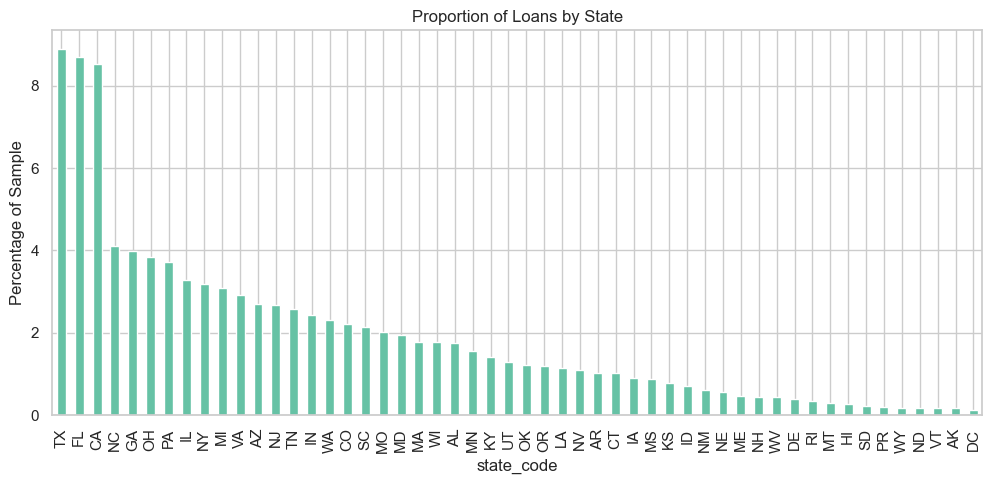

In [25]:
import matplotlib.pyplot as plt

state_dist.plot(kind='bar', figsize=(12,5), title='Proportion of Loans by State')
plt.ylabel('Percentage of Sample')
plt.show()

make a chart of all variables

In [26]:
import pandas as pd
import numpy as np

# --- Define all selected variables ---
cols_to_show = [
    # Location & Market Context
    'state_code', 'county_code', 'census_tract',
    'tract_population', 'tract_owner_occupied_units',
    'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units',
    'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',

    # Loan Characteristics
    'derived_loan_product_type', 'loan_type', 'loan_purpose', 'purchaser_type',
    'preapproval', 'lien_status', 'reverse_mortgage', 'open_end_line_of_credit',
    'business_or_commercial_purpose', 'loan_term', 'intro_rate_period',

    # Loan Performance & Decision Outcomes
    'action_taken', 'denial_reason_1', 'denial_reason_2',
    'denial_reason_3', 'denial_reason_4', 'hoepa_status',

    # Loan Amount & Financial Terms
    'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate', 'rate_spread',
    'total_loan_costs', 'total_points_and_fees', 'origination_charges',
    'discount_points', 'lender_credits',

    # Property Attributes
    'property_value', 'construction_method', 'derived_dwelling_category',
    'occupancy_type', 'manufactured_home_secured_property_type',
    'manufactured_home_land_property_interest', 'total_units',
    'multifamily_affordable_units',

    # Applicant Financial Profile
    'income', 'debt_to_income_ratio', 'applicant_credit_score_type',
    'co_applicant_credit_score_type',

    # Applicant Age & Lifecycle Indicators
    'applicant_age', 'co_applicant_age',
    'applicant_age_above_62', 'co_applicant_age_above_62'
]

# --- Create the base variable inventory ---
inventory = pd.DataFrame({
    'Variable Name': cols_to_show,
    'Data Type': [hmda_sample[col].dtype for col in cols_to_show],
    'Missing %': [hmda_sample[col].isna().mean() * 100 for col in cols_to_show]
})

# --- Dictionary of descriptions ---
descriptions = {
    'state_code': 'Two-letter US state code where the property is located',
    'county_code': 'FIPS code for the county',
    'census_tract': 'Census tract number where the property is located',
    'tract_population': 'Total population in the census tract',
    'tract_owner_occupied_units': 'Number of owner-occupied housing units in the tract',
    'tract_one_to_four_family_homes': 'Number of 1–4 family homes in the tract',
    'tract_median_age_of_housing_units': 'Median age of housing units in the tract (years)',
    'ffiec_msa_md_median_family_income': 'Median family income of the MSA/MD (from FFIEC data)',
    'tract_to_msa_income_percentage': 'Ratio of tract median income to MSA/MD median income (%)',
    'derived_loan_product_type': 'Type of loan product (e.g., conventional, FHA, VA)',
    'loan_type': 'Loan type: conventional, FHA, VA, RHS',
    'loan_purpose': 'Purpose of loan (home purchase, refinance, etc.)',
    'purchaser_type': 'Type of entity purchasing the loan (investor or agency)',
    'preapproval': 'Whether the applicant had preapproval for the loan',
    'lien_status': 'Lien position: first or subordinate',
    'reverse_mortgage': 'Whether the loan is a reverse mortgage',
    'open_end_line_of_credit': 'Whether the loan is an open-end line of credit',
    'business_or_commercial_purpose': 'Loan for business or commercial purposes',
    'loan_term': 'Loan term in months (e.g., 360)',
    'intro_rate_period': 'Introductory fixed-rate period for adjustable loans (months)',
    'action_taken': 'HMDA action taken code (loan originated, denied, withdrawn, etc.)',
    'denial_reason_1': 'Primary reason for denial of the loan',
    'denial_reason_2': 'Secondary reason for denial',
    'denial_reason_3': 'Third reason for denial',
    'denial_reason_4': 'Fourth reason for denial',
    'hoepa_status': 'Whether the loan is subject to HOEPA (high-cost mortgage)',
    'loan_amount': 'Original loan amount in dollars',
    'combined_loan_to_value_ratio': 'Combined loan-to-value ratio (%)',
    'interest_rate': 'Annual interest rate (%)',
    'rate_spread': 'Difference between loan rate and average prime offer rate',
    'total_loan_costs': 'Total loan costs paid by borrower',
    'total_points_and_fees': 'Total points and fees paid by borrower',
    'origination_charges': 'Charges for originating the loan',
    'discount_points': 'Discount points paid to reduce interest rate',
    'lender_credits': 'Lender credits applied to borrower',
    'property_value': 'Appraised value of the property',
    'construction_method': 'Construction type (site-built, modular, manufactured)',
    'derived_dwelling_category': 'Dwelling category (single family, multifamily)',
    'occupancy_type': 'Occupancy type: owner-occupied, rental, or second home',
    'manufactured_home_secured_property_type': 'Type of property for manufactured homes',
    'manufactured_home_land_property_interest': 'Land ownership type for manufactured home property',
    'total_units': 'Number of units in the property',
    'multifamily_affordable_units': 'Number of affordable units in multifamily property',
    'income': "Borrower's reported annual income ($)",
    'debt_to_income_ratio': "Borrower's debt-to-income ratio (%)",
    'applicant_credit_score_type': 'Type of applicant credit score reported',
    'co_applicant_credit_score_type': 'Type of co-applicant credit score reported',
    'applicant_age': "Borrower's age",
    'co_applicant_age': "Co-borrower's age",
    'applicant_age_above_62': 'Indicator if borrower is older than 62',
    'co_applicant_age_above_62': 'Indicator if co-borrower is older than 62'
}

# --- Map descriptions ---
inventory['Description'] = inventory['Variable Name'].map(descriptions)

# --- Add placeholder for relevance and mark key variables ---
inventory['Relevance (★ Key Vars)'] = ''
key_vars = ['census_tract', 'tract_population', 'loan_amount', 'state_code', 'action_taken', 'income', 'debt_to_income_ratio', 'county_code', 'loan_type', 'denial_reason_1', 'applicant_age', 'applicant_age_above_62']
inventory.loc[inventory['Variable Name'].isin(key_vars), 'Relevance (★ Key Vars)'] = '★'

# --- Reorder columns for readability ---
inventory = inventory[['Variable Name','Data Type','Description','Relevance (★ Key Vars)','Missing %']]

# --- Display full inventory in Jupyter ---
pd.set_option('display.max_rows', None)
display(inventory)


,Variable Name,Data Type,Description,Relevance (★ Key Vars),Missing %
0,state_code,object,Two-letter US state code where the property is...,★,0.000000
1,county_code,float64,FIPS code for the county,★,0.000000
2,census_tract,float64,Census tract number where the property is located,★,0.000000
3,tract_population,int64,Total population in the census tract,★,0.000000
4,tract_owner_occupied_units,int64,Number of owner-occupied housing units in the ...,,0.000000
5,tract_one_to_four_family_homes,int64,Number of 1–4 family homes in the tract,,0.000000
6,tract_median_age_of_housing_units,int64,Median age of housing units in the tract (years),,0.000000
7,ffiec_msa_md_median_family_income,int64,Median family income of the MSA/MD (from FFIEC...,,0.000000
8,tract_to_msa_income_percentage,float64,Ratio of tract median income to MSA/MD median ...,,0.000000
9,derived_loan_product_type,object,"Type of loan product (e.g., conventional, FHA,...",,0.000000


In [27]:
#Remove Duplicate Records
# ---------------------------
num_duplicates = hmda_sample.duplicated().sum()
print(f"Initial duplicates: {num_duplicates}")

# Drop exact duplicates
hmda_sample = hmda_sample.drop_duplicates()

# Confirm removal
num_duplicates_after = hmda_sample.duplicated().sum()
print(f"Remaining duplicates: {num_duplicates_after}")
print(f"Final dataset shape: {hmda_sample.shape}")

print([col for col in hmda_sample.columns if 'Unnamed' in col])


Initial duplicates: 1
Remaining duplicates: 0
Final dataset shape: (12014, 99)
[]


In [28]:
extra_cols = [col for col in hmda_sample.columns if col not in cols_to_show]
print(f"Extra columns ({len(extra_cols)}):\n", extra_cols)

hmda_sample = hmda_sample.drop(columns=extra_cols, errors='ignore')
print("Cleaned dataset shape:", hmda_sample.shape)



Extra columns (48):
 ['activity_year', 'lei', 'derived_msa_md', 'conforming_loan_limit', 'derived_ethnicity', 'derived_race', 'derived_sex', 'prepayment_penalty_term', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'applicant_ethnicity_1', 'applicant_ethnicity_2', 'applicant_ethnicity_3', 'applicant_ethnicity_4', 'applicant_ethnicity_5', 'co_applicant_ethnicity_1', 'co_applicant_ethnicity_2', 'co_applicant_ethnicity_3', 'co_applicant_ethnicity_4', 'co_applicant_ethnicity_5', 'applicant_ethnicity_observed', 'co_applicant_ethnicity_observed', 'applicant_race_1', 'applicant_race_2', 'applicant_race_3', 'applicant_race_4', 'applicant_race_5', 'co_applicant_race_1', 'co_applicant_race_2', 'co_applicant_race_3', 'co_applicant_race_4', 'co_applicant_race_5', 'applicant_race_observed', 'co_applicant_race_observed', 'applicant_sex', 'co_applicant_sex', 'applicant_sex_observed', 'co_applicant_sex_observed', 'submission_of_application', 'initi

check that the sample retained all columns correctly

In [29]:
hmda_sample.columns



Index(['state_code', 'county_code', 'census_tract',
       'derived_loan_product_type', 'derived_dwelling_category',
       'action_taken', 'purchaser_type', 'preapproval', 'loan_type',
       'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open_end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate',
       'rate_spread', 'hoepa_status', 'total_loan_costs',
       'total_points_and_fees', 'origination_charges', 'discount_points',
       'lender_credits', 'loan_term', 'intro_rate_period', 'property_value',
       'construction_method', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_units',
       'multifamily_affordable_units', 'income', 'debt_to_income_ratio',
       'applicant_credit_score_type', 'co_applicant_credit_score_type',
       'applicant_age', 'co_applicant_age', 'applicant_age_above_62',
       'co_applicant_age_abov

In [30]:

# view loan product types and its data type 
hmda_sample.derived_loan_product_type.unique()


array(['VA:First Lien', 'FHA:First Lien', 'Conventional:First Lien',
       'Conventional:Subordinate Lien', 'FSA/RHS:First Lien'],
      dtype=object)

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style
sns.set(style="whitegrid", palette="Set2")
plt.rcParams['figure.figsize'] = (10, 5)

# --- Univariate Analysis ---

# ACTION TAKEN DISTRIBUTION
plt.figure()
hmda_sample['action_taken_desc'].value_counts().plot(kind='bar')
plt.title('Distribution of Loan Actions Taken')
plt.xlabel('Action Taken')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# LOAN TYPE DISTRIBUTION
plt.figure()
hmda_sample['loan_type_desc'].value_counts().plot(kind='bar')
plt.title('Distribution of Loan Types')
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# LOAN PURPOSE DISTRIBUTION
plt.figure()
hmda_sample['loan_purpose_desc'].value_counts().plot(kind='bar')
plt.title('Distribution of Loan Purposes')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# AGE CATEGORY DISTRIBUTION
age_order = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74', 'Not provided']
hmda_sample['applicant_age'] = hmda_sample['applicant_age'].replace('8888', 'NA')
plt.figure()
hmda_sample['applicant_age'].value_counts().loc[age_order].plot(kind='bar')
plt.title('Distribution of Applicant Age Groups')
plt.xlabel('Applicant Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# # DENIAL REASONS (TOP 10)
# plt.figure()
# hmda_sample['denial_reason_1_desc'].value_counts().head(10).plot(kind='bar')
# plt.title('Primary Reasons for Loan Denial (Top 10)')
# plt.xlabel('Denial Reason')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# # NUMERIC VARIABLES EXAMPLE (Loan Amount)
# if 'loan_amount' in hmda_sample.columns:
#     plt.figure()
#     sns.histplot(hmda_sample['loan_amount'], bins=50, kde=True)
#     plt.title('Distribution of Loan Amounts')
#     plt.xlabel('Loan Amount ($)')
#     plt.ylabel('Frequency')
#     plt.tight_layout()
#     plt.show()

KeyError: 'action_taken_desc'

<Figure size 1000x500 with 0 Axes>

plot for loans originated in each state

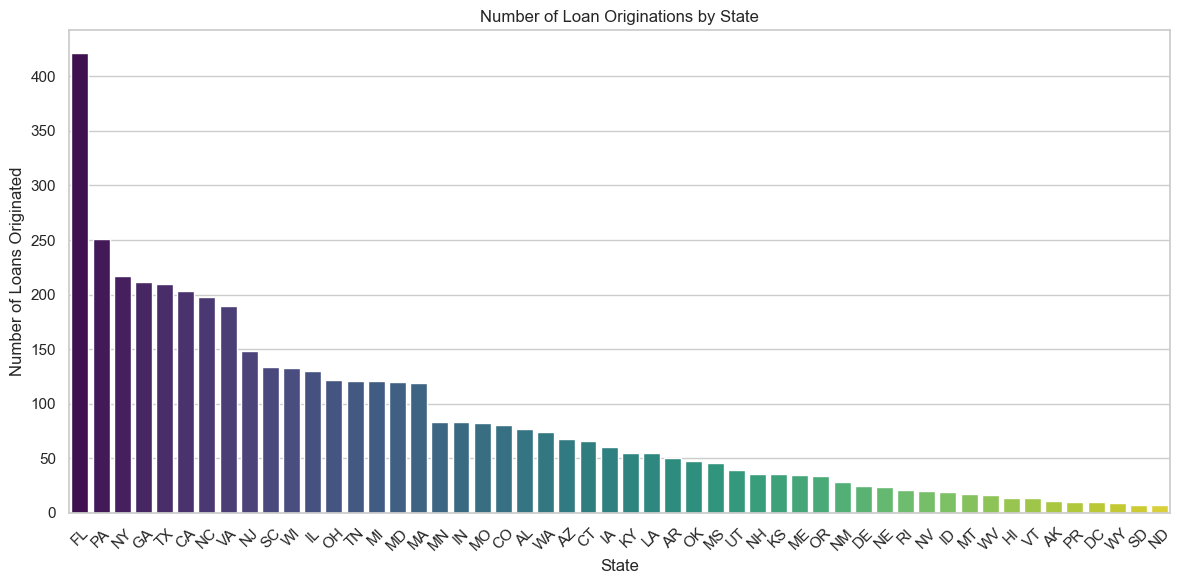

In [ ]:
# Filter only loans that were originated
originated = hmda_sample[hmda_sample['action_taken'] == 1]

# Count loans per state
state_counts = originated['state_code'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="viridis")
plt.title('Number of Loan Originations by State')
plt.xlabel('State')
plt.ylabel('Number of Loans Originated')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalized/Proportional view — percent of applications originated

In [ ]:
# Calculate proportion of originated loans per state
state_total = hmda_sample.groupby('state_code')['action_taken'].count()
state_originated = originated.groupby('state_code')['action_taken'].count()
state_proportion = (state_originated / state_total * 100).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=state_proportion.index, y=state_proportion.values, palette="magma")
plt.title('Percent of Loan Applications Originated by State')
plt.xlabel('State')
plt.ylabel('Percent of Applications Originated (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'originated' is not defined

1. Location & Market Context
These tell you where the loan activity is happening — useful for mapping or comparing areas.
Use these columns for:
Heatmaps or choropleths (loans or values by tract/county)
Comparing income or home age vs. loan volume

In [ ]:
# Inspect specific columns, e.g., state_code & county_code
display(hmda_sample[
['state_code', 'county_code', 'census_tract', 
 'tract_population', 'tract_owner_occupied_units', 
 'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units',
 'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage']].head())



,state_code,county_code,census_tract,tract_population,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage
0,AK,2020.0,2.020000e+09,6384,1787,2375,35,117200,110.0
1,AK,2020.0,2.020000e+09,5650,1680,2088,32,117200,136.0
2,AK,2240.0,2.240000e+09,4695,1081,2060,34,101300,103.0
3,AK,2150.0,2.150000e+09,6833,1067,2291,33,101300,120.0
4,AK,2020.0,2.020000e+09,3413,871,1096,36,117200,172.0


2. Loan Characteristics
These describe the type, purpose, and conditions of the loan itself.
Use these for:
Understanding how loan products vary by area
Spotting trends in commercial vs. residential or preapprovals

In [ ]:
display(hmda_sample[
['derived_loan_product_type', 'loan_type', 'loan_purpose', 'purchaser_type', 
 'preapproval', 'lien_status', 'reverse_mortgage', 'open_end_line_of_credit', 
 'business_or_commercial_purpose', 'loan_term', 'intro_rate_period']].head())


,derived_loan_product_type,loan_type,loan_purpose,purchaser_type,preapproval,lien_status,reverse_mortgage,open_end_line_of_credit,business_or_commercial_purpose,loan_term,intro_rate_period
0,VA:First Lien,3,1,0,2,1,2,2,2,333,NaN
1,FHA:First Lien,2,1,2,2,1,2,2,2,360,NaN
2,VA:First Lien,3,1,71,2,1,2,2,2,360,NaN
3,VA:First Lien,3,1,0,2,1,2,2,2,338,NaN
4,VA:First Lien,3,32,2,2,1,2,2,2,360,NaN


3. Loan Performance & Decision Outcomes
Use these for:
Mapping loan denial rates by region
Correlating denial reasons with applicant or property traits
Detecting where credit access is tightening

In [ ]:
display(hmda_sample[
['action_taken', 'denial_reason_1', 'denial_reason_2',
 'denial_reason_3', 'denial_reason_4', 'hoepa_status']].head())

,action_taken,denial_reason_1,denial_reason_2,denial_reason_3,denial_reason_4,hoepa_status
0,1,10,NaN,NaN,NaN,2
1,6,10,NaN,NaN,NaN,2
2,1,10,NaN,NaN,NaN,2
3,1,10,NaN,NaN,NaN,2
4,6,10,NaN,NaN,NaN,2


4. Loan Amount & Financial Terms
These measure how big or risky loans are.
Use these for:
Interest rate and cost trend analysis
Assessing loan affordability and market risk

In [ ]:
display(hmda_sample[
    ['loan_amount', 'combined_loan_to_value_ratio', 'interest_rate', 'rate_spread',
 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 
 'discount_points', 'lender_credits']
].head())

,loan_amount,combined_loan_to_value_ratio,interest_rate,rate_spread,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits
0,325000,91.263,2.75,NaN,66.0,NaN,0.0,NaN,NaN
1,325000,NaN,6.75,NaN,11576.02,NaN,2522.47,1727.47,NaN
2,345000,100.0,5.25,-0.795,2672.9,NaN,415.2,NaN,865.0
3,435000,100.0,3.375,NaN,3537.83,NaN,300.0,NaN,NaN
4,415000,NaN,6.25,NaN,31097.26,NaN,14090.77,14090.77,NaN


5. Property AttributesThese describe the property itself.
Use these for:
Exploring affordability or construction trends

In [ ]:
display(hmda_sample[
['property_value', 'construction_method', 'derived_dwelling_category', 
 'occupancy_type', 'manufactured_home_secured_property_type', 
 'manufactured_home_land_property_interest', 'total_units']
].head())

,property_value,construction_method,derived_dwelling_category,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units
0,365000.0,1,Single Family (1-4 Units):Site-Built,1,3,5,1
1,365000.0,1,Single Family (1-4 Units):Site-Built,1,3,5,1
2,345000.0,1,Single Family (1-4 Units):Site-Built,1,3,5,1
3,435000.0,1,Single Family (1-4 Units):Site-Built,1,3,5,1
4,525000.0,1,Single Family (1-4 Units):Site-Built,1,3,5,1


 6. Applicant Financial ProfileThese are borrower-level metrics (but still privacy-safe).
Use these for:
Exploring credit risk patterns
Correlating applicant income with loan approvals

In [ ]:
display(hmda_sample[
['income', 'debt_to_income_ratio', 'applicant_credit_score_type', 
 'co_applicant_credit_score_type']
].head())

,income,debt_to_income_ratio,applicant_credit_score_type,co_applicant_credit_score_type
0,77.0,30%-<36%,2,10
1,NaN,NaN,9,9
2,82.0,20%-<30%,1,10
3,123.0,36,3,9
4,NaN,NaN,9,9


7. Applicant Age & Lifecycle Indicators
help identify generational or lifecycle trends.
Use these for:
Identifying younger vs. older borrower markets
Supporting insights like “growing area attracting younger buyers”

In [ ]:
display(hmda_sample[
['applicant_age', 'co_applicant_age', 'applicant_age_above_62', 'co_applicant_age_above_62']
].head())

,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62
0,25-34,9999,No,NaN
1,8888,8888,NaN,NaN
2,55-64,9999,Yes,NaN
3,45-54,45-54,No,No
4,8888,8888,NaN,NaN


view the actions taken for loans and see what is most common outcomes

 Descriptions for action_taken numerical codes:
1. Loan originated
2. Application approved but not accepted
3. Application denied
4. Application withdrawn by applicant
5. File closed for incompleteness
6. Purchased loan
7. Preapproval request denied
8. Preapproval request approved but not accepted

In [ ]:
#Explore 'action_taken' column
# ---------------------------
# Show unique values
action_values = hmda_preview['action_taken'].unique()
print("Unique action_taken codes:", action_values)

# Count frequency of each code
action_counts = hmda_preview['action_taken'].value_counts().sort_index()
print("Frequency of each action_taken code:")
print(action_counts)

Unique action_taken codes: [3 1 2 5 4]
Frequency of each action_taken code:
action_taken
1    49
2     5
3    42
4     1
5     3
Name: count, dtype: int64


Logical Regression

creating a binary target

In [ ]:
hmda_sample['approved'] = hmda_sample['action_taken'].apply(
    lambda x: 1 if x == 1 else 0
)
print(hmda_sample[['action_taken', 'approved']].head())

   action_taken  approved
0             1         1
1             6         0
2             1         1
3             1         1
4             6         0
